# Install Packages

Use "!" to run bash commands

In [66]:
!pip install torch boto3 --user

     |████████████████████████████████| 133kB 8.6MB/s eta 0:00:01
     |████████████████████████████████| 6.8MB 12.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 24.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


Packages are installed locally for the user "jovyan". Add the path to sys.path so we can import the newly-installed packages.

In [102]:
import sys
sys.path.append('/home/jovyan/.local/lib/python3.6/site-packages')

Some convenient Jupyter extensions to enable automatic reloading of imported python modules (in case you change some \*.py file) as well as inline plotting.

In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import packages needed for this notebook

In [248]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 

import boto3
import botocore

If you have a GPU-enabled notebook, we will use it for torch operations.

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Generation

Generate a synthetic two-dimensional binary classification dataset

In [103]:
def generate_binary_data(N_examples=1000, seed=None):
    '''Generate N_examples points with two features each
    
    Args:
        seed: seed that should be fixed if want to generate same points again
    
    Returns:
        features: A 2-dimensional numpy array with one row per example and one column per feature
        target: A 1-dimensional numpy array with one row per example denoting the class - 0 or 1
    '''

    if seed is not None:
        np.random.seed(seed)

    features = []
    target = []

    for i in range(N_examples):
        #class = 0
        r = np.random.uniform() #class 0 has radius between 0 and 1
        theta = np.random.uniform(0, 2*np.pi) #class 0 has any angle between 0 and 360 degrees

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(0)

        #class = 1
        r = 3 + np.random.uniform() #class 1 has radius between 3+0=3 and 3+1=4
        theta = np.random.uniform(0, 2*np.pi) #class 1 has any angle between 0 and 360 degrees

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(1)

    features = np.array(features)
    target = np.array(target)

    return features, target    

def plot_binary_data(features, target):
    '''Plot the generated data
    '''
    
    plt.figure(figsize=(10,10))
    plt.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='Class 0')
    plt.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='Class 1')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Binary Classification Data')

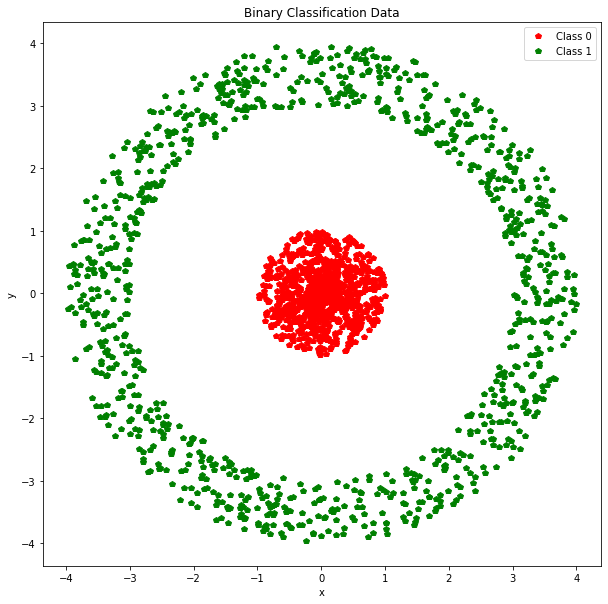

In [104]:
features, target = generate_binary_data(N_examples=1000, seed=100)
plot_binary_data(features, target)

# Data Storage

We will use the boto3 client to access an S3 store (MinIO). Ideally, the access and secret keys should be environment variables so they are not exposed in the repository.

In [107]:
#Create an S3 client to connect to the store

s3_endpoint_url = 'http://minio-kubeflow.apps.sanjay.dev.datahub.redhat.com'
s3_access_key = "minio"
s3_secret_key = "minio123"

s3 = boto3.client(service_name='s3',
                  aws_access_key_id = s3_access_key,
                  aws_secret_access_key = s3_secret_key, 
                  endpoint_url=s3_endpoint_url)

In [108]:
#Data is stored in so-called buckets. List all buckets
s3.list_buckets()['Buckets']

[{'Name': 'first-example',
  'CreationDate': datetime.datetime(2020, 11, 17, 14, 29, 42, 50000, tzinfo=tzlocal())},
 {'Name': 'mlpipeline',
  'CreationDate': datetime.datetime(2020, 11, 17, 0, 13, 54, 78000, tzinfo=tzlocal())}]

In [114]:
#Create a new bucket called 'first-example' if it doesn't already exist
try:
    s3.create_bucket(Bucket='first-example')
except botocore.exceptions.ClientError as e:
    print(e)

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [115]:
#Should see 'first-example' now
s3.list_buckets()['Buckets']

[{'Name': 'first-example',
  'CreationDate': datetime.datetime(2020, 11, 17, 14, 29, 42, 50000, tzinfo=tzlocal())},
 {'Name': 'mlpipeline',
  'CreationDate': datetime.datetime(2020, 11, 17, 0, 13, 54, 78000, tzinfo=tzlocal())}]

In [120]:
#Upload features and target to our bucket. They Key is a name we use to refer to the objects
s3.put_object(Body=features.tobytes(), Bucket='first-example', Key='features')
s3.put_object(Body=target.tobytes(), Bucket='first-example', Key='target')

{'ResponseMetadata': {'RequestId': '164856D7FA52D392',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'etag': '"40f99396ef31614ec0fa257493c47249"',
   'server': 'Minio/RELEASE.2018-02-09T22-40-05Z (linux; amd64)',
   'vary': 'Origin',
   'x-amz-request-id': '164856D7FA52D392',
   'date': 'Tue, 17 Nov 2020 15:59:12 GMT',
   'content-length': '0',
   'content-type': 'text/plain; charset=utf-8',
   'set-cookie': 'c58b009a839de7a40fe40da5a53579fe=e71acd7241f1253e784612a712a0fa6a; path=/; HttpOnly'},
  'RetryAttempts': 0},
 'ETag': '"40f99396ef31614ec0fa257493c47249"'}

In [121]:
#list all objects in the bucket
s3.list_objects_v2(Bucket='first-example')['Contents']

[{'Key': 'features',
  'LastModified': datetime.datetime(2020, 11, 17, 15, 59, 12, 753000, tzinfo=tzlocal()),
  'ETag': '"ccfd3f0d0a073c680e7e3c25396d4af5"',
  'Size': 32000,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}},
 {'Key': 'model.pkl',
  'LastModified': datetime.datetime(2020, 11, 17, 14, 29, 42, 50000, tzinfo=tzlocal()),
  'ETag': '"bf01b14dc043122935301699143f5078"',
  'Size': 2747,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}},
 {'Key': 'target',
  'LastModified': datetime.datetime(2020, 11, 17, 15, 59, 12, 769000, tzinfo=tzlocal()),
  'ETag': '"40f99396ef31614ec0fa257493c47249"',
  'Size': 16000,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}}]

In [172]:
#read objects from the bucket
features_from_bucket = s3.get_object(Bucket='first-example', Key='features')
features_from_bucket = np.frombuffer(features_from_bucket['Body'].read(), dtype=np.float).reshape(-1,2) #convert stream of bytes to numpy array

target_from_bucket = s3.get_object(Bucket='first-example', Key='target')
target_from_bucket = np.frombuffer(target_from_bucket['Body'].read(), dtype=np.uint)

#check these objects are the same
assert((features_from_bucket==features).all())
assert((target_from_bucket==target).all())

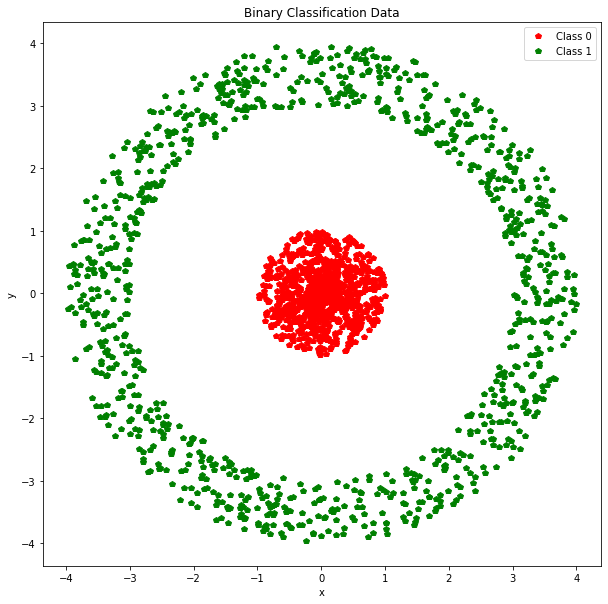

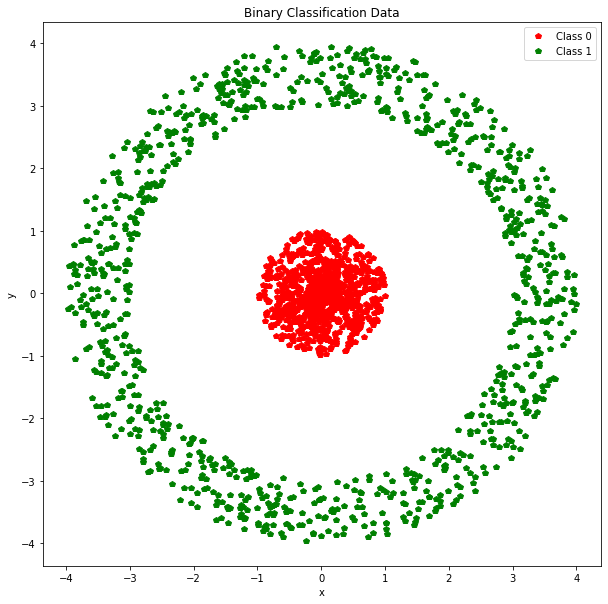

In [177]:
#plot both datasets
plot_binary_data(features, target)
plot_binary_data(features_from_bucket, target_from_bucket)

# Model Training

Let's define a PyTorch model by defining each layer

In [178]:
N_inputs = 2 #coordinates (x,y)
N_outputs = 1 #probability of belonging to class 1
N_hidden_nodes = 5 #<--- play with this

activation = nn.Sigmoid() #for multiple reasons, these are now generally nn.ReLU() units
output_activation = nn.Sigmoid() #expect probability between 0 and 1 i.e. use Sigmoids

#1 hidden layer, feed-forward neural network
net = nn.Sequential(nn.Linear(N_inputs, N_hidden_nodes),
                    activation,
                    nn.Linear(N_hidden_nodes, N_outputs),
                    output_activation
                   )

In [205]:
def train_model(features, target, model, lr, N_epochs, criterion=nn.BCELoss(), shuffle=False):
    #criterion = nn.BCELoss() #binary cross-entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam optimizer
    model.train()
    
    #if have gpu, move the model, features and labels on it
    if device!='cpu':
        model = model.to(device)
        features = features.to(device)
        target = target.to(device)

    for epoch in range(N_epochs): #N_epochs = number of iterations over the full dataset
        if shuffle: #should have no effect on gradients in this case
            indices = torch.randperm(len(features))

            features_shuffled = features[indices]
            target_shuffled = target[indices]
        else:
            features_shuffled = features
            target_shuffled = target

        out = model(features_shuffled) #predictions from model
        loss = criterion(out.squeeze(), target_shuffled.squeeze()) #loss between predictions and labels

        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')

        optimizer.zero_grad()
        loss.backward() #compute gradients
        optimizer.step() #update model

    if device!='cpu':
        model = model.to('cpu')
        features = features.to('cpu')
        target = target.to('cpu')

    return model

In [191]:
#convert features and target to torch tensors
features_tensor = torch.tensor(features).float()
target_tensor = torch.tensor(target).float()

#train
net = train_model(features_tensor, target_tensor, net, 1e-3, 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch = 0 loss = 0.0033675136510282755
epoch = 1000 loss = 0.0014406193513423204
epoch = 2000 loss = 0.0007781002204865217
epoch = 3000 loss = 0.0004648029862437397
epoch = 4000 loss = 0.0002922399144154042
epoch = 5000 loss = 0.00018898519920185208
epoch = 6000 loss = 0.00012419882114045322
epoch = 7000 loss = 8.241901377914473e-05
epoch = 8000 loss = 5.503396823769435e-05
epoch = 9000 loss = 3.6905770684825256e-05


# Save and Persist model

In [192]:
torch.save(net, 'model.pt')

In [193]:
net_from_file = torch.load('model.pt')

In [196]:
#can check that the weights between net and net_from_file are the same. See layer 1 weights below
print(list(net.parameters())[0])
print(list(net_from_file.parameters())[0])

Parameter containing:
tensor([[ 7.9668, -3.8380],
        [ 1.1889,  8.3778],
        [ 8.7215,  1.4314],
        [-4.0287,  7.7801],
        [ 6.6426,  6.6315]], requires_grad=True)
Parameter containing:
tensor([[ 7.9668, -3.8380],
        [ 1.1889,  8.3778],
        [ 8.7215,  1.4314],
        [-4.0287,  7.7801],
        [ 6.6426,  6.6315]], requires_grad=True)


In [197]:
#upload model to s3 bucket
s3.upload_file('model.pt', 'first-example', Key='model.pt')

In [198]:
#list objects in bucket
s3.list_objects_v2(Bucket='first-example')['Contents']

[{'Key': 'features',
  'LastModified': datetime.datetime(2020, 11, 17, 15, 59, 12, 753000, tzinfo=tzlocal()),
  'ETag': '"ccfd3f0d0a073c680e7e3c25396d4af5"',
  'Size': 32000,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}},
 {'Key': 'model.pkl',
  'LastModified': datetime.datetime(2020, 11, 17, 14, 29, 42, 50000, tzinfo=tzlocal()),
  'ETag': '"bf01b14dc043122935301699143f5078"',
  'Size': 2747,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}},
 {'Key': 'model.pt',
  'LastModified': datetime.datetime(2020, 11, 17, 17, 30, 53, 349000, tzinfo=tzlocal()),
  'ETag': '"129e8baf539772b0de87c90a8c70909e"',
  'Size': 2491,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}},
 {'Key': 'target',
  'LastModified': datetime.datetime(2020, 11, 17, 15, 59, 12, 769000, tzinfo=tzlocal()),
  'ETag': '"40f99396ef31614ec0fa257493c47249"',
  'Size': 16000,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '', 'ID': ''}}]

In [200]:
#download file
s3.download_file(Filename='model.pt', Bucket='first-example', Key='model.pt')

# Create REST Endpoint

TODO

# Appendix

#### PyTorch API

PyTorch has a much more flexible API for defining neural network architectures than the nn.Sequential constructor used above. It involves:

* Creating a class inheriting from nn.Module
* The constructor __init__ is used to define the various layers and units in the network
* The class is callable i.e. it implements __call__ and calls the function forward by default which defines the exact flow of data in the network.

ClassifierNet below is a generic feed-forward neural network where all the hidden layers have the same number of nodes.

In [201]:
class ClassifierNet(nn.Module): #inherit from nn.Module to define your own architecture
    def __init__(self, N_inputs, N_outputs, N_hidden_layers, N_hidden_nodes, activation, output_activation):
        super(ClassifierNet, self).__init__()
        
        self.N_inputs = N_inputs #2 in our case
        self.N_outputs = N_outputs #1 in our case but can be higher for multi-class classification
        
        self.N_hidden_layers = N_hidden_layers #we'll start by using one hidden layer
        self.N_hidden_nodes = N_hidden_nodes #number of nodes in each hidden layer - can extend to passing a list
        
        #Define layers below - pytorch has a lot of layers pre-defined
        
        #use nn.ModuleList or nn.DictList instead of [] or {} - more explanations below
        self.layer_list = nn.ModuleList([]) #use just as a python list
        for n in range(N_hidden_layers):
            if n==0:
                self.layer_list.append(nn.Linear(N_inputs, N_hidden_nodes))
            else:
                self.layer_list.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.output_layer = nn.Linear(N_hidden_nodes, N_outputs)
        
        self.activation = activation #activations at inner nodes
        self.output_activation = output_activation #activation at last layer (depends on your problem)
        
    def forward(self, inp):
        '''
        every neural net in pytorch has its own forward function
        this function defines how data flows through the architecture from input to output i.e. the forward propagation part
        '''
        
        out = inp
        for layer in self.layer_list:
            out = layer(out) #calls forward function for each layer (already implemented for us)
            out = self.activation(out) #non-linear activation
            
        #pass activations through last/output layer
        out = self.output_layer(out)
        if self.output_activation is not None:
            pred = self.output_activation(out)
        else:
            pred = out
        
        return pred

#### Validation

The main goal of machine learning is generalization i.e. the model should be able to predict not just on data seen during training but also on new data (following the same joint distribution as the training data).

This is done empirically by splitting the data into two chunks - the training data (say, 80%) and test data (20% in this case). The model is trained using the training data and evaluated on the test dataset.

Notes: 

* The split 80%-20% is an example. There is no hard rule on what the split should be and it is dependent on the amount of data one has.

* There are many ways to approach validation. It is also common to split the data into three pieces - train, validation and test sets. The train piece is used for training, validation for tuning hyperparameters in the model (number of layers, activations etc.) and the test to evaluate how well the model with the final hyperparameters does. Another approach is K-fold cross-validation. The reader is encouraged to read up on these since validation is a crucial aspect of the scientific process of training a model.

Since we have artificially generated data, instead of splitting the dataset, we can just generate a new test set.

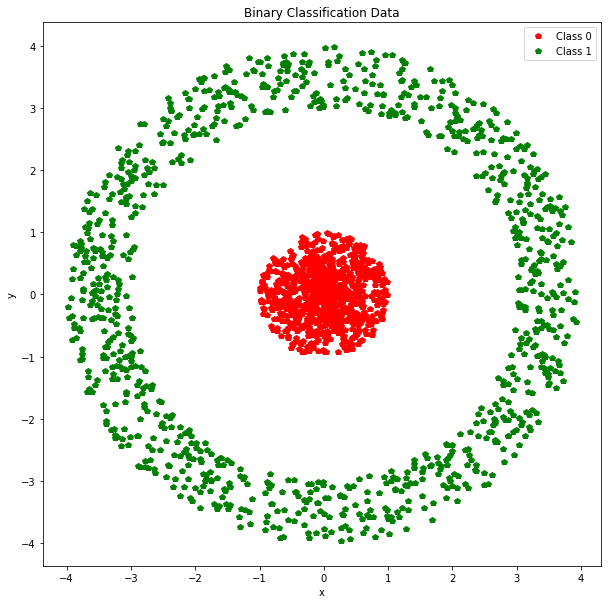

In [203]:
features_test, target_test = generate_binary_data(N_examples=1000, seed=999) #note, we changed the seed
plot_binary_data(features_test, target_test)

Since we already have a trained model, let's evaluate it on both the train set and the test and compared accuracies.

In [225]:
(pred_train > 0.5).int()

tensor([0, 1, 0,  ..., 1, 0, 1], dtype=torch.int32)

In [216]:
features_tensor.shape

torch.Size([2000, 2])

In [211]:
pred_train.shape

torch.Size([1000])

In [214]:
target_tensor.shape

torch.Size([2000])

In [229]:
pred_train = net(features_tensor).squeeze()
pred_train = (pred_train > 0.5).int()
train_accuracy = (pred_train == target_tensor).sum() / pred_train.shape[0]
print(f'Train Accuracy = {train_accuracy}')

Train Accuracy = 1.0


In [231]:
pred_test = net(torch.from_numpy(features_test).float()).squeeze()
pred_test = (pred_test > 0.5).int()
test_accuracy = (pred_test == torch.from_numpy(target_test)).sum() / pred_test.shape[0]
print(f'Test  Accuracy = {test_accuracy}')

Test  Accuracy = 1.0


In this simple example, we see an accuracy of 100\% not only on the train set but also on a different test set (geenrated by the same function used to generate the train set but not the same dataset). This indicates that the model does generalize well i.e. it hasn't just memorized the answers for the train set but can predict on new data as well.

#### Interpretation

A neural network that predicts well and generalizes to data not seen before is very useful practically as one can imagine. At the same time, it is fruitful:

* INTERPRETATION 2D
* INTERPRETATION 3D -> Coordinate transformations

In [262]:
def plot_2d_interpretation(features, target, net):
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot()

    #plot raw data
    ax.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    ax.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

    plt.xlabel('x')
    plt.ylabel('y')

    #get weights and biases
    params = list(net.parameters())
    weights = params[0].detach().numpy()
    biases = params[1].detach().numpy()

    #plot straight lines
    x_min, x_max = features[:,0].min(), features[:,0].max()
    y_lim_min, y_lim_max = features[:,1].min(), features[:,1].max()
    for i in range(weights.shape[0]): #loop over each hidden node in the one hidden layer
        coef = weights[i]
        intercept = biases[i]

        y_min = (-intercept - coef[0]*x_min)/coef[1]
        y_max = (-intercept - coef[0]*x_max)/coef[1]

        ax.plot([x_min, x_max], [y_min, y_max])

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.legend(framealpha=0)
    
def plot_3d_interpretation(features, target, net, activations_to_plot=[0,1,2]):
    assert(len(activations_to_plot)==3)
    
    #get hidden layer activations for all inputs
    layer1_activations = net[1](net[0](features)).detach().numpy()
    
    #plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    
    ix1, ix2, ix3 = activations_to_plot
    
    ax.plot(layer1_activations[target==0][:,ix1], layer1_activations[target==0][:,ix2], layer1_activations[target==0][:,ix3], 'p', color ='r', label='0')
    ax.plot(layer1_activations[target==1][:,ix1], layer1_activations[target==1][:,ix2], layer1_activations[target==1][:,ix3], 'p', color ='g', label='1')

    ax.legend(framealpha=0)    
    
    ax.set_xlabel(f'Activation {ix1}')
    ax.set_ylabel(f'Activation {ix2}')
    ax.set_zlabel(f'Activation {ix3}')

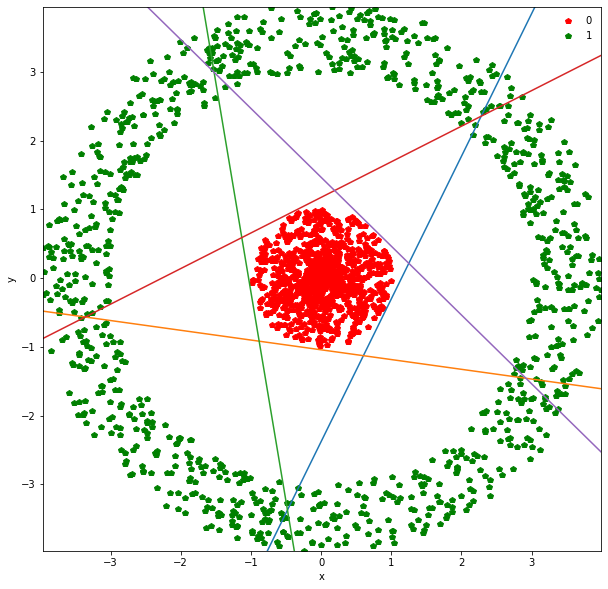

In [250]:
plot_2d_interpretation(features, target, net)

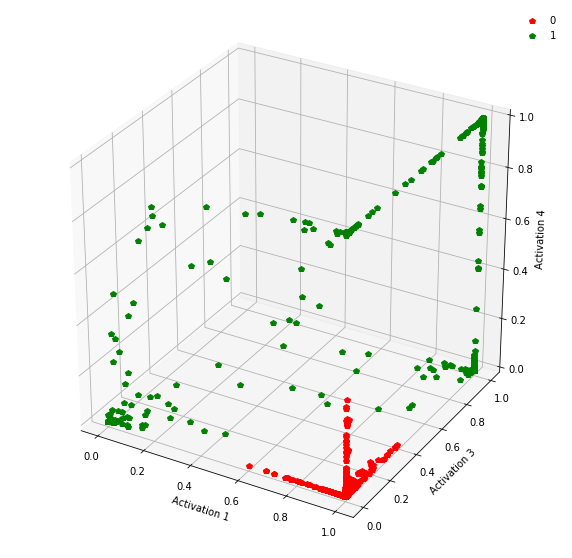

In [263]:
plot_3d_interpretation(features, target, net, activations_to_plot=[1,3,4])

In [62]:
class SeldonPredictor(object):
    def __init__(self, model_filename):
        self.model = torch.load(model_filename)
        
    def predict(self, X):        
        features = torch.from_numpy(X)
        
        pred = self.model(features)
        
        return pred.detach().numpy()